# 06b: CNN-LSTM Model Optimization and Evaluation

This notebook provides a comprehensive, stepwise workflow for evaluating and optimizing the trained CNN-LSTM model for ICU mortality prediction.

**Goals:**
- Load test data and trained model for robust evaluation
- Compute key metrics (AUROC, AUPRC, confusion matrix, classification report)
- Visualize model performance with ROC and Precision-Recall curves
- Perform hyperparameter tuning and advanced analysis
- Summarize findings to guide clinical interpretation and future improvements

---

## Workflow Overview
1. **Importing Libraries & Configuration:** Set up the environment and import required packages.
2. **Loading and Validating Data:** Load test data and trained model, confirm shapes and alignment.
3. **Model Evaluation:** Compute AUROC, AUPRC, confusion matrix, and classification report.
4. **Performance Visualization:** Plot ROC and Precision-Recall curves for model interpretation.
5. **Hyperparameter Tuning:** Use KerasTuner to optimize model architecture and training settings.
6. **Summary & Interpretation:** Summarize results and provide clinical insights.

In [2]:
# Imports and Configuration
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import keras_tuner as kt
import pickle
import os
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
import shap


C:\Users\jegullin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Load data and model
data = np.load('../data/processed/cnn_lstm_data.npz', allow_pickle=True)
X_test, y_test = data['X_test'], data['y_test']
static_test = data['static_test']

# Sanity check: ensure all arrays are aligned
print('X_test shape:', X_test.shape)
print('static_test shape:', static_test.shape)
print('y_test shape:', y_test.shape)

# Load the best model from Keras Tuner
model_path = '../models/cnn_lstm_best_model.keras'
if not os.path.exists(model_path):
    model_path = '../models/cnn_lstm_final_model.keras'
model = load_model(model_path)

X_test shape: (800, 202, 24)
static_test shape: (800, 9)
y_test shape: (800,)


## 1. Model Evaluation: AUROC, Classification Report, ROC & PR Curves

This section evaluates the trained CNN-LSTM model using robust metrics and visualizations to assess its performance on the test set.

- **AUROC (Area Under the Receiver Operating Characteristic Curve):** Measures the model's ability to distinguish between classes. A higher AUROC indicates better discrimination.
- **Classification Report:** Provides precision, recall, f1-score, and support for each class, offering a detailed breakdown of model performance.
- **Confusion Matrix:** Summarizes true positives, false positives, true negatives, and false negatives.
- **ROC Curve:** Plots the true positive rate against the false positive rate at various threshold settings, visualizing the trade-off between sensitivity and specificity.
- **Precision-Recall (PR) Curve:** Plots precision versus recall, especially useful for imbalanced datasets.

These metrics and plots provide a comprehensive view of the model's effectiveness and help guide further optimization and clinical interpretation.

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
AUROC: 0.999AUROC: 0.999
AUPRC: 0.995
Confusion Matrix:
 [[674  15]
 [  0 111]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       689
         1.0       0.88      1.00      0.94       111

    accuracy                           0.98       800
   macro avg       0.94      0.99      0.96       800
weighted avg       0.98      0.98      0.98       800


AUPRC: 0.995
Confusion Matrix:
 [[674  15]
 [  0 111]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       689
         1.0       0.88      1.00      0.94       111

    accuracy                           0.98       800
   macro avg       0.94      0.99      0.96       800
weighted avg       0.98      0.98      0.98       800



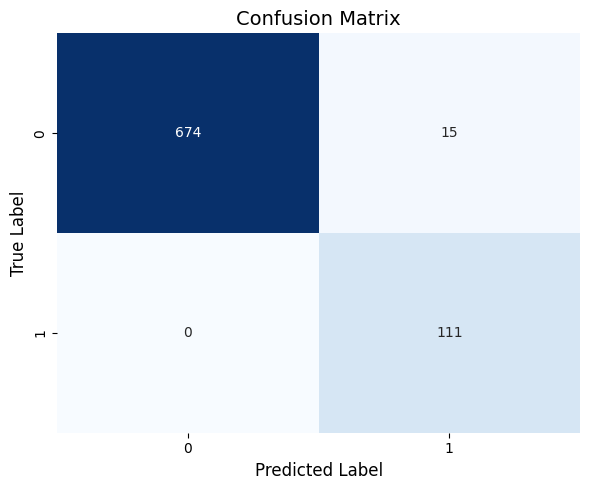

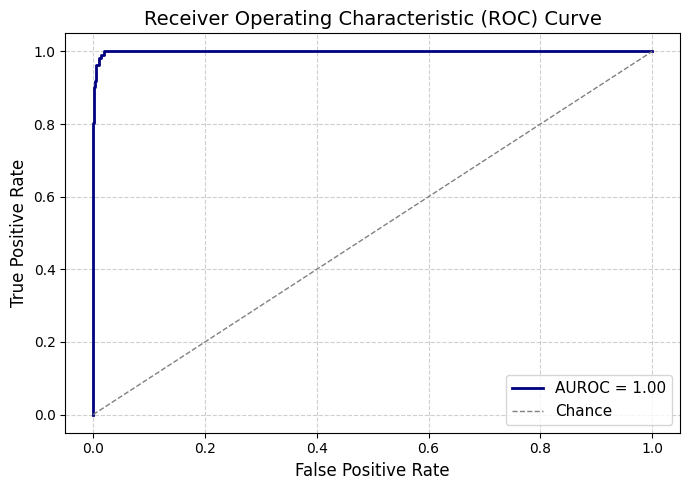

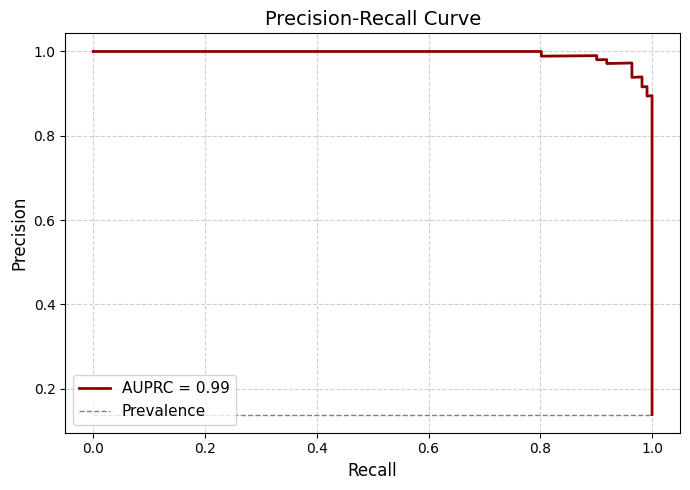

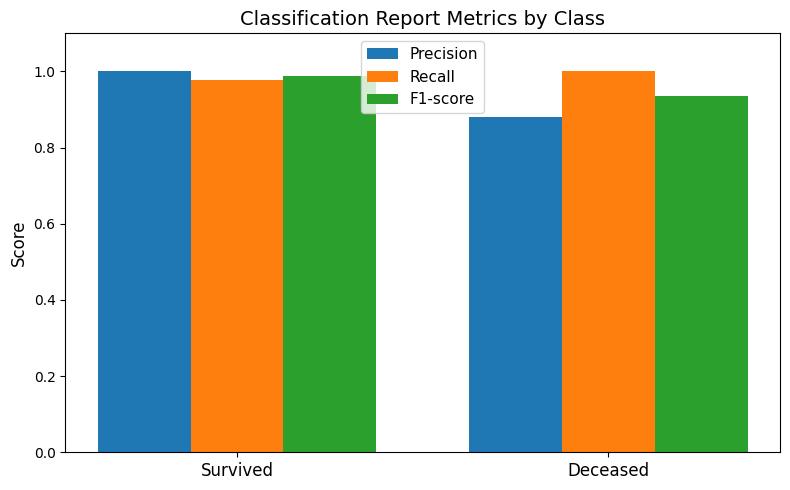

In [27]:
# Predict probabilities and classes
y_pred_prob = model.predict([X_test, static_test]).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
auroc = roc_auc_score(y_test, y_pred_prob)
auprc = average_precision_score(y_test, y_pred_prob)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"AUROC: {auroc:.3f}")
print(f"AUPRC: {auprc:.3f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='navy', lw=2, label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, color='darkred', lw=2, label=f'AUPRC = {auprc:.2f}')
plt.hlines(y=np.mean(y_test), xmin=0, xmax=1, color='gray', lw=1, linestyle='--', label='Prevalence')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(loc='lower left', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


labels = [0, 1]
metrics_names = ['Precision', 'Recall', 'F1-score']
prfs = precision_recall_fscore_support(y_test, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.25
x = np.arange(len(labels))
for i, metric in enumerate(metrics_names):
    ax.bar(x + i*bar_width, prfs[i], width=bar_width, label=metric)
ax.set_xticks(x + bar_width)
ax.set_xticklabels(['Survived', 'Deceased'], fontsize=12)
ax.set_ylim(0, 1.1)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Classification Report Metrics by Class', fontsize=14)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

## 2. ROC and Precision-Recall Curves

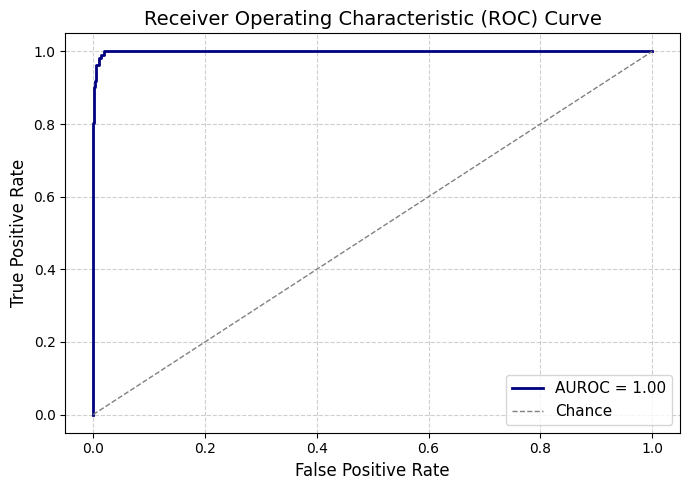

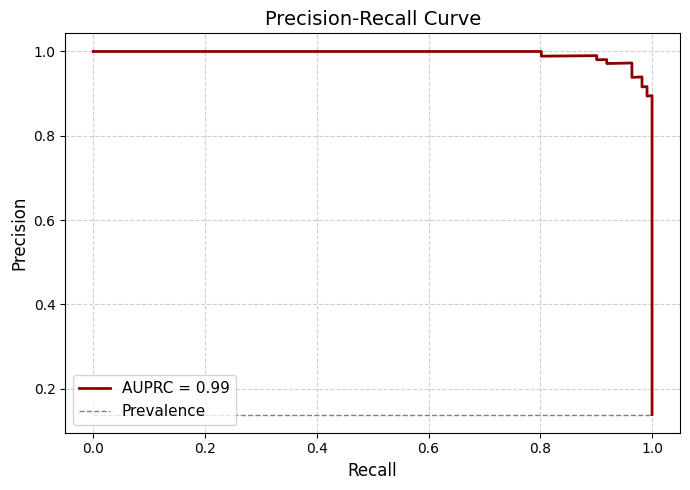

In [21]:
# ROC Curve 
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='navy', lw=2, label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Precision-Recall Curve 
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, color='darkred', lw=2, label=f'AUPRC = {auprc:.2f}')
plt.hlines(y=np.mean(y_test), xmin=0, xmax=1, color='gray', lw=1, linestyle='--', label='Prevalence')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(loc='lower left', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 3. Hyperparameter Tuning with KerasTuner

To optimize the CNN-LSTM model for ICU mortality prediction, we use KerasTuner to search for the best combination of model parameters (CNN filters, LSTM units, dropout rate, learning rate, etc.).

This workflow helps identify the most effective architecture and training settings for our specific dataset and task.

In [24]:
# Hyperparameter Tuning with Keras Tuner
train_data = np.load('../data/processed/cnn_lstm_data.npz', allow_pickle=True)
X_train, y_train = train_data['X_train'], train_data['y_train']
X_val, y_val = train_data['X_val'], train_data['y_val']
static_train, static_val = train_data['static_train'], train_data['static_val']


def build_model(hp):
    seq_input = Input(shape=(X_train.shape[1], X_train.shape[2]), name='seq_input')
    filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    x = Conv1D(filters=filters, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(seq_input)
    x = Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1))(x)
    x = Conv1D(filters=filters, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1))(x)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    x = LSTM(lstm_units, return_sequences=False, kernel_regularizer=l2(1e-4))(x)
    x = Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1))(x)
    static_input = Input(shape=(static_train.shape[1],), name='static_input')
    concat = Concatenate()([x, static_input])
    dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
    dense = Dense(dense_units, activation='relu', kernel_regularizer=l2(1e-4))(concat)
    output = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=[seq_input, static_input], outputs=output)
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['AUC', 'Precision', 'Recall'])
    return model

# Tuner to optimize hyperparameters
tuner = kt.RandomSearch(
    build_model,
    objective='val_AUC',  
    max_trials=10,
    executions_per_trial=1,
    directory='kt_cnn_lstm',
    project_name='ICU_mortality'
)

# Run the hyperparameter search
tuner.search([X_train, static_train], y_train,
             validation_data=([X_val, static_val], y_val),
             epochs=30,
             batch_size=64)

# Retrieve and display the best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print('Best hyperparameters found:', best_hp.values)

Trial 10 Complete [00h 02m 55s]
val_AUC: 0.989457368850708

Best val_AUC So Far: 0.9979097843170166
Total elapsed time: 01h 09m 06s
Best hyperparameters found: {'filters': 128, 'dropout_rate': 0.30000000000000004, 'lstm_units': 64, 'dense_units': 16, 'learning_rate': 0.009614466105066123}
